In [1]:
import numpy as np
from TransportMaps.Distributions.Examples import InertialNavigationSystem as INS
from TransportMaps.Algorithms import SequentialInference as ALGSI
import TransportMaps.Distributions as DIST
import TransportMaps.Diagnostics as DIAG
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.size'] = 15

# Inertial Navigation System

Here we revisit the Intertial Navigation System (INS) problem [[OR10](aa-references.html#brown1997),[OR11](aa-references.html#bona1966)] which we set up [here](pm-data-assimilation.html#Linear-Gaussian-model). 
Overall, we are interested in the estimation of the gyroscope's "biases" ${\bf Z}^({4:6})_k$ at times $k\in\Lambda=0,\ldots,n$, of the state-space model 

$$
{\bf Z}_{k+1} = \Phi {\bf Z}_k + {\bf w}_k \;, \quad
{\bf Z}_0 \sim \mathcal{N}({\bf 0},{\bf Q}_0) \;, \quad
{\bf w}_k \sim \mathcal{N}({\bf 0},{\bf Q}) \\
{\bf Y}_k = H {\bf Z}_k + {\bf v}_k \;, \quad
{\bf v}_k \sim \mathcal{N}({\bf 0}, {\bf R}) \;,
$$

where the observations ${\bf Y}_\Xi$, are taken at the times $\Xi \subset \Lambda$. 

Let us generate some sythetic trajectory ${\bf Z}_{\Lambda}$ and data ${\bf Y}_\Xi$, for $n=96$ (corresponding to $48\,{\rm h}$), and let us assume we miss observation 20-28.

In [2]:
def plot_dynamic(T,Z,i):
    plt.subplot(2,3,i+1); plt.plot(T,Z); plt.ylabel(r"${\bf z}_%d$ [rad]"%(i+1)); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
def plot_dynamics(T,Z):
    plt.figure(figsize=(15,10))
    for i in range(6):
        plot_dynamic(T,Z[:,i],i)
    plt.tight_layout()
def plot_data(T,Y):
    plt.figure(figsize=(15,5))
    y1 = [y[0] if y is not None else None for y in Y]
    plt.subplot(131); plt.plot(T,y1,'.'); plt.ylabel(r"$y_1$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
    y2 = [y[1] if y is not None else None for y in Y]
    plt.subplot(132); plt.plot(T,y2,'.'); plt.ylabel(r"$y_2$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
    y3 = [y[2] if y is not None else None for y in Y]
    plt.subplot(133); plt.plot(T,y3,'.'); plt.ylabel(r"$y_3$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
    plt.tight_layout()

In [3]:
nsteps = 96
T,Z,Y = INS.generate_data(nsteps)
for n in range(20,29):
    Y[n] = None
plot_dynamics(T,Z); plot_data(T,Y);

## Kalman filter
Let us first solve the classic problem of characterizing the filtering distributions $\pi\left({\bf Z}_k\middle\vert {\bf Y}_{\Xi \leq k}\right)$. Since all the operators are linear and all the distributions involved are Gaussians, also the filtering distributions must be Gaussians and can be recovered using the Kalman filter [[OR12](aa-references.html#kalman1960)].

In [4]:
pi_prior = INS.Prior()
pi_trans = INS.Transition()
FLT = ALGSI.LinearFilter()
for n in range(nsteps+1):
    # Define log-likelihood
    if Y[n] is None: # Missing data
        ll = None
    else: 
        ll = INS.LogLikelihood(Y[n])
    # Define transition / prior
    if n > 0: 
        pin = pi_trans
    else:
        pin = pi_prior
    # Assimilation
    print("%3d" % n, end="")
    FLT.assimilate(pin, ll)

  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96

Now we can query the filter for the means and covariances at every step and  compare them with the synthetic dynamics.

In [5]:
def plot_dynamic_vs_track(T,Z,M,C,i):
    plt.subplot(2,3,i+1); 
    plt.plot(T,Z,label=r'${\bf Z}$');
    plt.plot(T,M,'k-',label=r'$\mathbb{E}{\bf Z}$');
    conf = 1.96 * np.sqrt(C)
    plt.fill_between(T,M-conf,M+conf,color='r',alpha=0.3)
    plt.ylabel(r"${\bf z}_%d$ [rad]"%(i+1)); plt.xlabel("T [h]"); 
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
def plot_dynamics_vs_tracks(T,Z,M,C):
    plt.figure(figsize=(15,10))
    for i in range(6):
        mean = [m[i] for m in M]
        var = [cov[i,i] for cov in C]
        plot_dynamic_vs_track(T,Z[:,i],mean,var,i)
    plt.tight_layout()

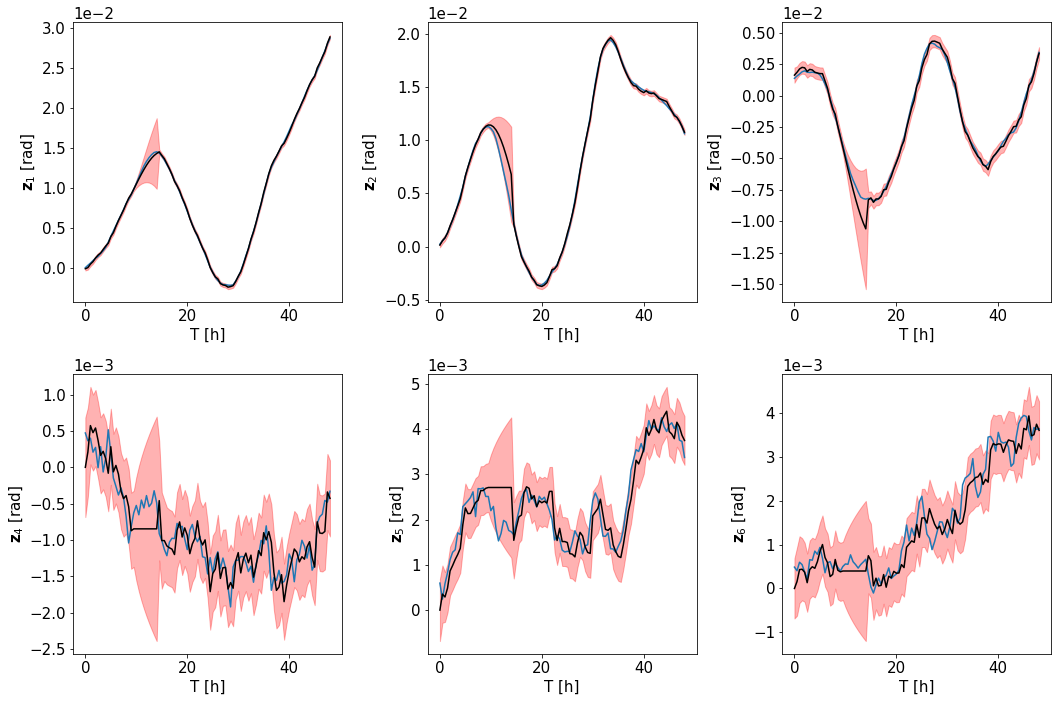

In [6]:
mean_list = FLT.filtering_mean_list
cov_list = FLT.filtering_covariance_list
plot_dynamics_vs_tracks(T,Z,mean_list,cov_list)

## Linear smoother

In [7]:
SMT = ALGSI.LinearSmoother(lag=None)
for n in range(nsteps+1):
    # Define log-likelihood
    if Y[n] is None: # Missing data
        ll = None
    else: 
        ll = INS.LogLikelihood(Y[n])
    # Define transition / prior
    if n > 0: 
        pin = pi_trans
    else:
        pin = pi_prior
    # Assimilation
    print("%3d" % n, end="")
    SMT.assimilate(pin, ll)

  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96

In [8]:
M = SMT.smoothing_map
pi = SMT.pi
pull_M_pi = DIST.PullBackTransportMapDistribution(M, pi)
rho = DIST.StandardNormalDistribution(pi.dim)
var_seq = DIAG.variance_approx_kl(rho, pull_M_pi, qtype=0, qparams=1000)
print("Variance diagnostic - Sequential: %e" % var_seq)

Variance diagnostic - Sequential: 1.437433e-24


In [9]:
push_M_rho = DIST.PushForwardTransportMapDistribution(M, rho)
samps = push_M_rho.rvs(10000)
plt.figure(figsize=(15,10))
for i in range(6):
    mean = np.mean(samps[:,i::6],axis=0)
    var = np.var(samps[:,i::6],axis=0)
    plot_dynamic_vs_track(T,Z[:,i],mean,var,i)
plt.tight_layout()

In [10]:
mean_list = SMT.smoothing_mean_list
cov_list = SMT.smoothing_covariance_list
plot_dynamics_vs_tracks(T,Z,mean_list,cov_list)

Let us try to reduce the smoothing lag and check the accuracy.

In [11]:
lags = 2**np.arange(1,6,dtype=int)
plt.figure(figsize=(10,5))
for i,lag in enumerate(lags):
    mean_list_lag, cov_list_lag = SMT.offline_smoothing_mean_covariance_lists(lag=int(lag))
    # Root mean square error in mean and covariance
    rmse_mean = []
    rmse_cov = []
    for m, c, ml, cl in zip(mean_list, cov_list, mean_list_lag, cov_list_lag):
        rmse_mean.append( np.sqrt(np.sum( (m-ml)**2 )) / np.sqrt(np.sum( (m)**2 )) )
        rmse_cov.append( np.sqrt(np.sum( (c-cl)**2 )) / np.sqrt(np.sum( (c)**2 )) )
    plt.subplot(1,2,1); plt.semilogy(T,rmse_mean,label='lag=%d'%lag); 
    plt.subplot(1,2,2); plt.semilogy(T,rmse_cov,label='lag=%d'%lag);
plt.subplot(1,2,1); plt.ylabel("RMSE"); plt.xlabel("T [h]"); plt.title("Mean"); plt.legend();
plt.subplot(1,2,2); plt.xlabel("T [h]"); plt.title("Covariance");
plt.tight_layout()